# Рекомендация тарифов

В вашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы (из проекта курса «Статистический анализ данных»). Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не понадобится — вы её уже сделали.

Постройте модель с максимально большим значением *accuracy*. Чтобы сдать проект успешно, нужно довести долю правильных ответов по крайней мере до 0.75. Проверьте *accuracy* на тестовой выборке самостоятельно.

Оператор мобильной связи «Мегалайн» выяснил: многие клиенты пользуются архивными тарифами. Они хотят построить систему, способную проанализировать поведение клиентов и предложить пользователям новый тариф: «Смарт» или «Ультра».

**Описание данных**

Каждый объект в наборе данных — это информация о поведении одного пользователя за месяц. 

Известно:

- сalls — количество звонков,
- minutes — суммарная длительность звонков в минутах,
- messages — количество sms-сообщений,
- mb_used — израсходованный интернет-трафик в Мб,
- is_ultra — каким тарифом пользовался в течение месяца («Ультра» — 1, «Смарт» — 0).

## Откройте и изучите файл

In [1]:
#блок загрузки библиотек

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
pd.options.display.float_format = '{:.2f}'.format
from joblib import dump
from joblib import load
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.dummy import DummyClassifier   

In [2]:
# код загрузки датасета

try:
    tariffs = pd.read_csv('/datasets/users_behavior.csv')
except:
    tariffs = pd.read_csv('/Users/vadimprimakov/Documents/Yandex_practicum/CSV/06_users_behavior.csv')
    
display(tariffs.head())     

,calls,minutes,messages,mb_used,is_ultra
0,40.00,311.90,83.00,19915.42,0
1,85.00,516.75,56.00,22696.96,0
2,77.00,467.66,86.00,21060.45,0
3,106.00,745.53,81.00,8437.39,1
4,66.00,418.74,1.00,14502.75,0


**Изучим общую информацию по предоставленным данным, выявим, что относится к fearures, а что к target**

Предобработка данных по заданию не требуется, но на данный момент изменим тип данных у столбцов 
calls и messages на целочисленный 

In [3]:
tariffs.shape 

(3214, 5)

In [4]:
tariffs.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


In [5]:
display(tariffs.describe())

,calls,minutes,messages,mb_used,is_ultra
count,3214.00,3214.00,3214.00,3214.00,3214.00
mean,63.04,438.21,38.28,17207.67,0.31
std,33.24,234.57,36.15,7570.97,0.46
min,0.00,0.00,0.00,0.00,0.00
25%,40.00,274.58,9.00,12491.90,0.00
50%,62.00,430.60,30.00,16943.24,0.00
75%,82.00,571.93,57.00,21424.70,1.00
max,244.00,1632.06,224.00,49745.73,1.00


In [6]:
tariffs['calls'] = tariffs['calls'].astype('int')
tariffs['messages'] = tariffs['messages'].astype('int')

**Корреляционный анализ факторов**

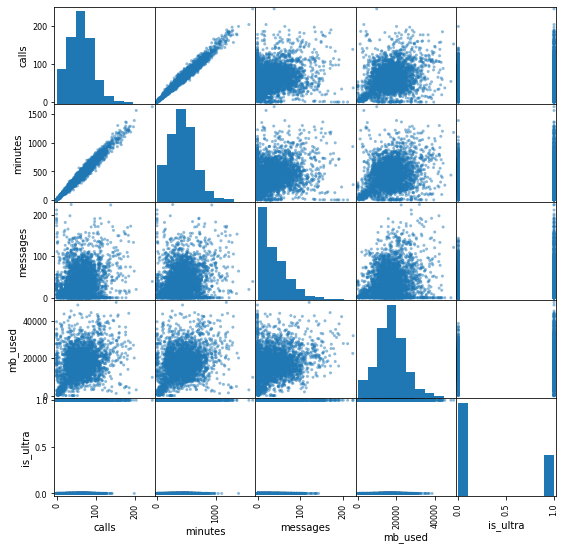

In [7]:
pd.plotting.scatter_matrix(tariffs, figsize=(9, 9)) 
plt.show()

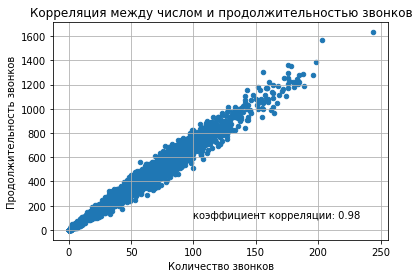

In [8]:
tariffs.plot(x='calls', y='minutes', kind='scatter', grid=True) 
plt.text(100, 100, 'коэффициент корреляции: ' + str(round(tariffs['calls'].corr(tariffs['minutes']), 2)))
plt.title("Корреляция между числом и продолжительностью звонков")
plt.ylabel("Продолжительность звонков")
plt.xlabel("Количество звонков")
plt.show()

Между количеством звонков и продолжительностью существует практически полная положительная связь. Один из признаков можно убрать.

In [9]:
tariffs.drop(['calls'], axis='columns', inplace=True)

**Вывод**

В приведенных данных была произведена замена типа данных по признаками Calls и Messages. В данных есть мультиколлинеарность в признаках calls и minutes. Поэтому после проверки было принято решение избавиться от лишнего признака calls.

## Разбейте данные на выборки

**Разделение исходных данных на выборки**

Данные разобьем на три части: обучающую, валидационную и тестовую. Исходные данные разбивают в соотношении 3:1:1

In [10]:
features = tariffs.drop(['is_ultra'], axis=1)
target = tariffs['is_ultra']

In [11]:
features_train, features_test, target_train, target_test = train_test_split(features, 
                                                                            target, 
                                                                            test_size=0.4, 
                                                                            random_state=12345
                                                                           ) 

**Размер обучающей выборки**

In [12]:
print(features_train.shape)
print(target_train.shape)

(1928, 3)
(1928,)


In [13]:
features_valid, features_test, target_valid, target_test = train_test_split(features_test, 
                                                                            target_test, 
                                                                            test_size=0.5, 
                                                                            random_state=12345
                                                                           ) 

**Размер валидационной выборки**

In [14]:
print(features_valid.shape)
print(target_valid.shape)

(643, 3)
(643,)


**Размер тестовой выборки**

In [15]:
print(features_test.shape)
print(target_test.shape)

(643, 3)
(643,)


## Исследуйте модели

**Decision Tree Classifier**

In [16]:
best_model_dtc = None
best_depth_dtc = 0
best_result_dtc = 0
for depth in range(1, 11):
    model_dtc = DecisionTreeClassifier(random_state=12345, max_depth = depth).fit(features_train, target_train)
    predictions_valid_dtc = model_dtc.predict(features_valid)
    result_dtc = accuracy_score(predictions_valid_dtc, target_valid)
    print('depth:', depth, ' accuracy:', result_dtc) 
    if best_result_dtc < result_dtc:
        best_model_dtc = model_dtc
        best_depth_dtc = depth
        best_result_dtc = result_dtc     

depth: 1  accuracy: 0.7542768273716952
depth: 2  accuracy: 0.7822706065318819
depth: 3  accuracy: 0.7853810264385692
depth: 4  accuracy: 0.7884914463452566
depth: 5  accuracy: 0.7884914463452566
depth: 6  accuracy: 0.7744945567651633
depth: 7  accuracy: 0.7713841368584758
depth: 8  accuracy: 0.7744945567651633
depth: 9  accuracy: 0.7791601866251944
depth: 10  accuracy: 0.7698289269051322


In [17]:
print('Лучший показатель accuracy:','{:.4f}'.format(best_result_dtc))
print('Лучшая грубина дерева =', best_depth_dtc)    

Лучший показатель accuracy: 0.7885
Лучшая грубина дерева = 4


**Вывод**

Точность лучшей модели из десяти равно 0.7885, с гиперпараметром - глубина дерева равным 4.

**Random Forest Classifier**

In [18]:
best_model_rfc = None
best_est_rfc = 0
best_depth_rfc = 0
best_result_rfc = 0
for est in range(2, 15, 3):
    for depth in range(5, 15):
        model_rfc = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth).fit(features_train, target_train)
        predictions_valid_rfc = model_rfc.predict(features_valid)
        result_rfc = accuracy_score(predictions_valid_rfc, target_valid)
        if best_result_rfc < result_rfc:
            best_model_rfc = model_rfc
            best_est_rfc = est
            best_depth_rfc = depth
            best_result_rfc = result_rfc            

In [19]:
print('Лучший показатель accuracy:','{:.4f}'.format(best_result_rfc))
print('Лучшая грубина дерева =', best_depth_rfc) 
print('Лучшее количество оценщиков =', best_est_rfc)    

Лучший показатель accuracy: 0.7963
Лучшая грубина дерева = 7
Лучшее количество оценщиков = 14


**Вывод**

Точность лучшей модели из десяти равно 0.7963, с гиперпараметром - глубина дерева равным 7 и количество оценщиков равным 14.

**Logistic Regression**

In [20]:
model_lr = LogisticRegression(random_state=12345).fit(features_train, target_train)
predictions_valid_lr = model_lr.predict(features_valid)
accuracy_lr = accuracy_score(predictions_valid_lr, target_valid)   

In [21]:
print('Лучший показатель accuracy:','{:.4f}'.format(accuracy_lr))

Лучший показатель accuracy: 0.7076


**Вывод**

Точность модели Логистической регресии равна 0.7076. 

Точность наилучшей модели на валидационной выборке ожидаемо показал случайный лес, с показателем - 0.7963

## Проверьте модель на тестовой выборке

Наиболее эффективной моделью стал - RandomForestClassifier, поэтому проверим ее на тестовой выборке

In [22]:
model_rfc = RandomForestClassifier(random_state=12345, n_estimators = 14, max_depth = 7).fit(features_train, target_train)
predictions_test_rfc = model_rfc.predict(features_test)
result_test_rfc = accuracy_score(predictions_test_rfc, target_test)

In [23]:
print('Точность RandomForestClassifier:','{:.4f}'.format(result_test_rfc))

Точность RandomForestClassifier: 0.8040


## (бонус) Проверьте модели на адекватность

Простейшая модель, которая всегда предсказывает наиболее часто встречающийся класс

In [24]:
model_dc = DummyClassifier(strategy='most_frequent', random_state=12345)
model_dc.fit(features_train, target_train)
result_dc = model_dc.score(features_valid, target_valid)
print('Точность простейшей модели:','{:.4f}'.format(result_dc))

Точность простейшей модели: 0.7061


Простейшая модель ошибается в чуть менее чем 30% случаев, выбранная в чуть менее 20%.
Выбранная модель лучше, чем простейшая модель. Проверка на адекватность пройдена.
Одной из целей проекта для успешного прохождения было - довести долю правильных ответов по крайней мере до 0.75. В нашем случае мы получили 0.8040, что говорит нам о достижении поставленной задачи 